In [1]:
import numpy as np
import astropy as ap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math as m
import argparse
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import custom_model
from matplotlib.backends.backend_pdf import PdfPages
import scipy as sp
import uncertainties as unc
import uncertainties
from uncertainties import unumpy as unp
import kcorrect
import kcorrect.utils as ut
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import matplotlib as mp
import os

In [2]:
cosmo=FlatLambdaCDM(H0=70.0,Om0=0.3)
fit=LevMarLSQFitter()

In [3]:
def autolabel(rects,thecolor,row,col,standard_height=0):
    for rect in rects:
        if rect.xy[0]<-16:
            height=rect.get_height()
            if not standard_height:
                if not m.isinf(height):
                    axes[row][col].text(rect.get_x() + rect.get_width()/2.,height+0.05,'{}'.format(int(np.round(np.power(10,height)))),ha='center',va='bottom',fontsize=7,color=thecolor)
            else:
                if not m.isinf(height):
                    axes[row][col].text(rect.get_x() + rect.get_width()/2.,standard_height,'{}'.format(int(np.round(np.power(10,height)))),ha='center',va='bottom',fontsize=7,color=thecolor)

In [4]:
@custom_model
def schechter_func(x,phistar=0.0056,mstar=-21,alpha=-1.03):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(alpha+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

In [5]:
def schechter_func_scipy(x,phistar,mstar,alpha):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(alpha+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

In [6]:
def ap_fitting(DATAFRAME,MASK=None):
    if MASK==None:
        MASK=[]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    print(NUMBDENS.compressed())
    #******MODELLING******
    LFFIT_INIT=schechter_func()
    LFFIT=fit(LFFIT_INIT,MBINAVE.compressed(),NUMBDENS.compressed(),weights=1/NUMBDENSERR.compressed())
    return LFFIT,NUMBDENS.mask

In [7]:
def sp_fitting(DATAFRAME,MASK=None,INITARRAY=None):
    if MASK==None:
        MASK=[]
    if INITARRAY==None:
        INITARRAY=[0.0056,-21,-1.03]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    #******MODELLING******
    LFFIT,LFCOV=sp.optimize.curve_fit(schechter_func_scipy,MBINAVE.compressed(),NUMBDENS.compressed(),p0=INITARRAY,sigma=NUMBDENSERR.compressed())
    return LFFIT,LFCOV

In [8]:
GAL_DIR='/Users/lucashunt/Projects/LCBG_LUMINOSITY_FUNCTION/FULLLFOUT'
GAL_LFS={}
GAL_LFS_INDEX=[]
for file in os.listdir(GAL_DIR):
    if file.endswith('csv'):
        GAL_LFS[file.split('.csv')[0]]=pd.read_csv(GAL_DIR+'/'+file)
        GAL_LFS_INDEX.append(file.split('.csv')[0])

In [9]:
GAL_MASKS={GAL_LFS_INDEX[0]:[2,3],GAL_LFS_INDEX[1]:[1,2,14,15],GAL_LFS_INDEX[2]:[11,12,13,14],GAL_LFS_INDEX[3]:[9],GAL_LFS_INDEX[4]:[7]}

The below dict is designed to mask one, two, three, etc. more points than the typical mask. The typical mask removes points that don't sample the full volume of the survey. This is for testing GAL_LFS_INDEX[1], or the redshift range from z=0.2-0.4

In [10]:
ALPHA_MASKS={'NoMASK':[1,2,14,15],'OneMASK':[1,2,13,14,15],'TwoMASK':[1,2,12,13,14,15],'ThreeMASK':[1,2,11,12,13,14,15],'FourMASK':[1,2,10,11,12,13,14,15],'FiveMASK':[1,2,9,10,11,12,13,14,15]}

In [11]:
alpha_test_fits={}
for mask in ALPHA_MASKS:
    alpha_test_fits[mask]=ap_fitting(GAL_LFS[GAL_LFS_INDEX[1]],MASK=ALPHA_MASKS[mask])

[ 0.00020073  0.00024253  0.00053835  0.00094967  0.00229317  0.00240043
  0.00298251  0.0047969   0.00621247  0.0060656   0.00857387  0.018185
  0.01179267]
[ 0.00020073  0.00024253  0.00053835  0.00094967  0.00229317  0.00240043
  0.00298251  0.0047969   0.00621247  0.0060656   0.018185    0.01179267]
[ 0.00020073  0.00024253  0.00053835  0.00094967  0.00229317  0.00240043
  0.00298251  0.0047969   0.00621247  0.018185    0.01179267]
[ 0.00020073  0.00024253  0.00053835  0.00094967  0.00229317  0.00240043
  0.00298251  0.0047969   0.018185    0.01179267]
[ 0.00020073  0.00024253  0.00053835  0.00094967  0.00229317  0.00240043
  0.00298251  0.018185    0.01179267]
[ 0.00020073  0.00024253  0.00053835  0.00094967  0.00229317  0.00240043
  0.018185    0.01179267]


In [12]:
alpha_test_fits

{'NoMASK': (<schechter_func(phistar=0.0031390362392495225, mstar=-20.741230121089085, alpha=-1.3343067963495094)>,
  array([ True,  True,  True, False, False, False, False, False, False,
         False, False, False, False, False,  True,  True, False, False], dtype=bool)),
 'OneMASK': (<schechter_func(phistar=0.003040465508035936, mstar=-20.771777480863562, alpha=-1.337330413440791)>,
  array([ True,  True,  True, False, False, False, False, False, False,
         False, False, False, False,  True,  True,  True, False, False], dtype=bool)),
 'TwoMASK': (<schechter_func(phistar=0.0033701006228564526, mstar=-20.677350484563906, alpha=-1.324472015062444)>,
  array([ True,  True,  True, False, False, False, False, False, False,
         False, False, False,  True,  True,  True,  True, False, False], dtype=bool)),
 'ThreeMASK': (<schechter_func(phistar=0.0030886438785836788, mstar=-20.754061185859484, alpha=-1.3365773690391258)>,
  array([ True,  True,  True, False, False, False, False, Fal

In [13]:
np.array(ALPHA_MASKS.keys())

array(dict_keys(['NoMASK', 'OneMASK', 'TwoMASK', 'ThreeMASK', 'FourMASK', 'FiveMASK']), dtype=object)

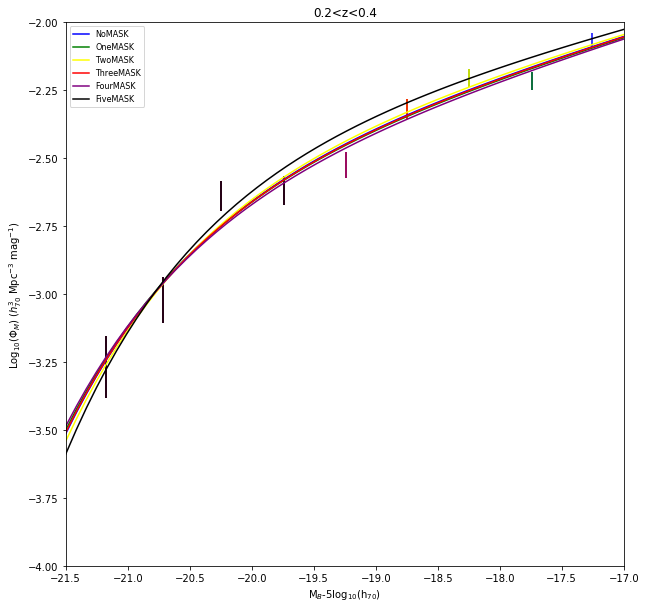

In [17]:
plt.figure(figsize=(10,10))
magrange=np.linspace(-24,-16,100)
color={'NoMASK':'blue','OneMASK':'green','TwoMASK':'yellow','ThreeMASK':'red','FourMASK':'purple','FiveMASK':'black'}
lines=[]
for mask in ALPHA_MASKS:
    lines+=plt.plot(magrange,
                    np.log10(alpha_test_fits[mask][0](magrange)),
                    label=mask,color=color[mask])
    plt.errorbar(GAL_LFS[GAL_LFS_INDEX[1]]['Average_Absolute_Magnitude'][np.logical_not(alpha_test_fits[mask][1])],
                 GAL_LFS[GAL_LFS_INDEX[1]]['Log10Phi'][np.logical_not(alpha_test_fits[mask][1])],
                 yerr=GAL_LFS[GAL_LFS_INDEX[1]]['Log10Err'][np.logical_not(alpha_test_fits[mask][1])],
                 linestyle='',color=color[mask])
plt.legend(lines,('NoMASK','OneMASK','TwoMASK','ThreeMASK','FourMASK','FiveMASK'),fontsize=8)
plt.ylim((-4,-2))
plt.xlim((-21.5,-17))
plt.xlabel('M$_{B}$-5log$_{10}$(h$_{70}$)')
plt.ylabel('Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)')
plt.title('0.2<z<0.4')

plt.savefig('/Users/lucashunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/PLOTS/LF_alpha_fitting_test.pdf')
plt.savefig('/Users/lucashunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/PLOTS/LF_alpha_fitting_test.png')
